<a href="https://colab.research.google.com/github/SoniaPMi/AI-3-RL/blob/main/maze_ecuaciones_lineales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo del laberinto. Función de valor de una política (Evaluación de políticas) con ecuaciones lineales.

Vamos a revisar esta implementación del ejercicio del laberinto que hemos visto en las diapositivas y que procede del libro de Sutton & Barto, en la que resolveremos el problema mediante el sistema de ecuaciones lineales que se plantea.

In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################


 Definimos las estructuras de datos:  
 * Definimos las coordenadas de las posiciones especiales A, B, A', B'. 
   Ten en cuenta que los índices comienzan por 0 en python
 * Definimos  la variable DISCOUNT que es nuestra Gamma de teoria a un valor 0.9
 * La variable WORL_SIZE nos define un tablero o matriz de 5x5
 * El vector Actions define con dos códigos el cambio de índices en el tablero al moverse 
   ejemplo: estoy en [2,2], elijo la accion 'left', con  lo que sumo [2,2] + [0,-1] = [2,1] y estoy 
   una posición a la izquierda
 * La constante ACTION_PROB es la probabilidad de cada acción
 
    -

In [1]:

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

matplotlib.use('Agg')

WORLD_SIZE = 5
A_POS = [0, 1]
A_PRIME_POS = [4, 1]
B_POS = [0, 3]
B_PRIME_POS = [2, 3]
DISCOUNT = 0.9

# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTIONS_FIGS=[ '←', '↑', '→', '↓']


ACTION_PROB = 0.25

#E, N, O, S
ACTION_PROB2 = [0.4, 0.2, 0.1, 0.3]



La siguiente función 'step' implementa el paso elemental s_t,a_t,r_{t+1},s_{t+1},a_{t+1}
- Si el estado actual es 'A' o 'B', salto a los puntos 'A'' o 'B'' y devuelvo la recompensa +10 ó +5 
- Sino, hago el movimiento, sumándole al estado la acción (como hemos explicado antes) y compruebo si me he salido fuera del tablero.
    - Si he salido, devuelvo -1 y vuelvo al estado anterior
    - Si no he salido, devuelvo 0

In [2]:
def step(state, action):
    if state == A_POS:
        return A_PRIME_POS, 10
    if state == B_POS:
        return B_PRIME_POS, 5

    next_state = (np.array(state) + action).tolist()
    x, y = next_state
    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        reward = -1.0
        next_state = state
    else:
        reward = 0
    return next_state, reward


Las dos funciones (celdas de código) siguientes no tienen interés algorítmico. Son para dibujar la imagen de los resultados del tablero.

In [3]:
def draw_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(image):

        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        if [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        if [i, j] == B_POS:
            val = str(val) + " (B)"
        if [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')
        

    # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')

    ax.add_table(tb)

In [4]:
def draw_policy(optimal_values):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = optimal_values.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(optimal_values):
        next_vals=[]
        for action in ACTIONS:
            next_state, _ = step([i, j], action)
            next_vals.append(optimal_values[next_state[0],next_state[1]])

        best_actions=np.where(next_vals == np.max(next_vals))[0]
        val=''
        for ba in best_actions:
            val+=ACTIONS_FIGS[ba]
        
        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        if [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        if [i, j] == B_POS:
            val = str(val) + " (B)"
        if [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height, text=val,
                loc='center', facecolor='white')

    # Row and column labels...
    for i in range(len(optimal_values)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                   edgecolor='none', facecolor='none')

    ax.add_table(tb)

### Resolución de las ecuaciones

La función figure_3_2_linear_system() implementa el cálculo analítico mediante resolución del sistema de ecuaciones lineales.

In [5]:
def figure_3_2_linear_system():
    '''
    Here we solve the linear system of equations to find the exact solution.
    We do this by filling the coefficients for each of the states with their 
    respective right side constant.
    '''
    A = -1 * np.eye(WORLD_SIZE * WORLD_SIZE)
    b = np.zeros(WORLD_SIZE * WORLD_SIZE)
    
    #AQUI PREPARA LAS MATRICES R y P de teoria
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):
            s = [i, j]  # current state
            index_s = np.ravel_multi_index(s, (WORLD_SIZE, WORLD_SIZE))
            for a in ACTIONS:
                s_, r = step(s, a)
                index_s_ = np.ravel_multi_index(s_, (WORLD_SIZE, WORLD_SIZE))

                #A[index_s, index_s_] += ACTION_PROB * DISCOUNT
                ind=next((i for i, val in enumerate(ACTIONS) if np.all(val == a)), -1)
                A[index_s, index_s_] += ACTION_PROB2[ind] * DISCOUNT
                #b[index_s] -= ACTION_PROB * r
                b[index_s] -= ACTION_PROB2[ind] * r

    x = np.linalg.solve(A, b)
    
    draw_policy(np.round(x.reshape(WORLD_SIZE, WORLD_SIZE), decimals=2))
    plt.savefig('figure_policy_linear.png')
    
    draw_image(np.round(x.reshape(WORLD_SIZE, WORLD_SIZE), decimals=2))
    plt.savefig('figure_3_2_linear_system.png')
    
    
    plt.close()


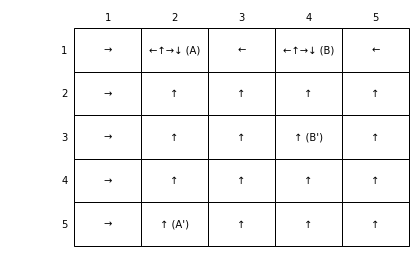

In [6]:

if __name__ == '__main__':
    figure_3_2_linear_system()
    


# Ejercicio: 
Modifica ahora la política para hallar la función de valor correspondiente a otra política.
Vamos a considerar la política determinista: P(N)=0.2 P(S)= 0.3, P(E) = 0.4 P(O) = 0.1
Modifica el código anterior y calcula la nueva función de valor asociada a esta política

La solucion es:<img src="sol2.png">
